Using Open Bandits Pipeline **[1]**

**[1]** https://arxiv.org/pdf/2008.07146.pdf

/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-05 10:55:08.926092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 10:55:09.520123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


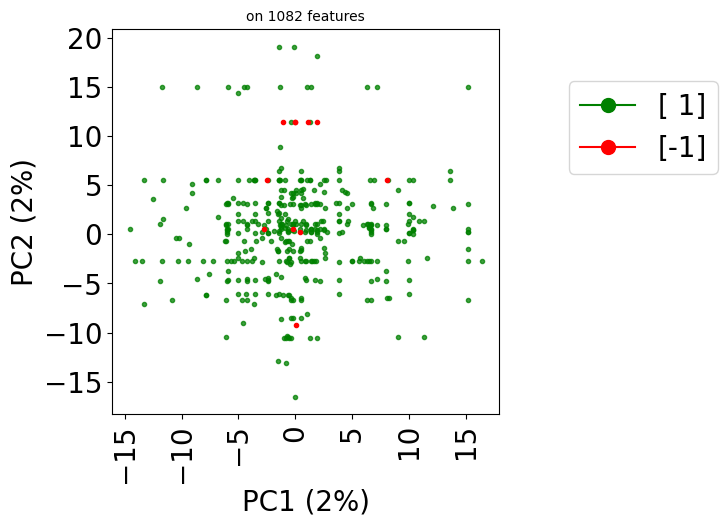

In [1]:
from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset

## Load dataset
transcript_args = load_dataset("TRANSCRIPT")
transcript_args.update({"name": "TRANSCRIPT", "same_item_user_features": True})
transcript = Dataset(**transcript_args)

transcript.visualize(withzeros=False)

In [2]:
from importlib import reload
import sys
sys.path.insert(0,"src/")
import benchscofi

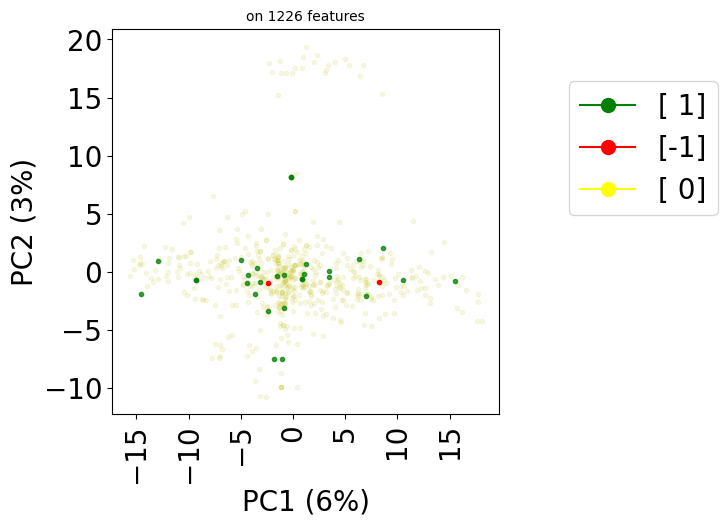

In [47]:
## Restrict to a single disease
import numpy as np

## Which is the disease with the most ratings?
disease_idx = np.argmax(np.abs(transcript.ratings_mat).sum(axis=0))
disease_folds = np.asarray(np.zeros((transcript.ratings_mat.shape[0],3)), dtype=int)
disease_folds[:,0] = disease_idx
disease_folds[:,1] = list(range(transcript.ratings_mat.shape[0]))
disease_folds[:,2] = transcript.ratings_mat[:,disease_idx].ravel()
subset = transcript.get_folds(disease_folds) ## restrict to that disease

subset.visualize(withzeros=True)

In [3]:
## Directly use a_i+theta ~ log(FC) as action feature vectors 
import numpy as np

def same_feature_preprocessing(dataset):
    assert dataset.same_item_user_features
    y = np.ravel(dataset.ratings_mat.flatten())
    S_, P_ = dataset.items.T.copy(), dataset.users.T.copy()
    P_[np.isnan(P_)] = 0
    S_[np.isnan(S_)] = 0
    ids = np.argwhere(np.ones(dataset.ratings_mat.shape)) # (item, user) pairs
    X = np.concatenate(tuple([
        np.add(S_[i, :], P_[j, :]).reshape(-1,1) ## a_i+theta
        for i, j in ids.tolist()
    ]), axis=1).T ## pairs x features
    return X, y

In [32]:
X, y = same_feature_preprocessing(subset)
(X.shape, y.shape)

((31, 12096), (31,))

In [ ]:
from obp.dataset import MultiClassToBanditReduction
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW

In [63]:
random_seed=12345

from sklearn.linear_model import LogisticRegression

dataset = MultiClassToBanditReduction(X=X, y=y, 
                    base_classifier_b=LogisticRegression(random_state=random_seed))
dataset.split_train_eval(eval_size=0.7, random_state=random_seed)
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=random_seed)

# obtain action choice probabilities of an evaluation policy
action_dist = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForestClassifier(random_state=random_seed)
)
# calculate the ground-truth performance of the evaluation policy
ground_truth = dataset.calc_ground_truth_policy_value(action_dist=action_dist)
print("Ground truth perf = %.3f" % ground_truth)

# Off-Policy Evaluation
ope = OffPolicyEvaluation(bandit_feedback=bandit_feedback, ope_estimators=[IPW()])
# evaluate the estimation performance (accuracy) of IPW by the relative estimation 
# error (relative-ee)
relative_estimation_errors = ope.evaluate_performance_of_estimators(
        ground_truth_policy_value=ground_truth,
        action_dist=action_dist,
        metric="relative-ee",
)
print("Relative EE (%s) = %.3f" % [(k,relative_estimation_errors[k])
                                         for k in relative_estimation_errors][0])

Ground truth perf = 0.955
Relative EE (ipw) = 0.111


In [50]:
action_dist.shape ## TODO why 22 down from 31??

(22, 2, 1)